In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 1

import numpy as np
import scipy.stats
import scipy.fft
import scipy.interpolate

import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

%aimport w7x_bes_tools.detectors
from w7x_bes_tools import detectors

rng = np.random.default_rng()
savefig = False

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Diode, TIA, and Inst. SNR
=====

In [2]:
diode = detectors.ApdDiode(
        name='Hama. S8550 4x8 APD',
        qe=0.85,  # QE @ 650 nm
        gain=50,  # gain @ Vr=330 V
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ Vr=330V, M=50
        junction_cap_ref=9e-12,  # typ 9 pF @ Vr=330V, M=50
        noise_index=0.2,
        vb_ref=330,  # reference bias for gain and junction cap.
    )

tia = detectors.TIA()

Hama. S8550 4x8 APD
  QE = 85.0 %
  Resp. = 0.45 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 9.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 330 V
  Ref. temp. = 20 C
  Gain = 50
  Noise index = 0.20
  Noise factor = 2.2


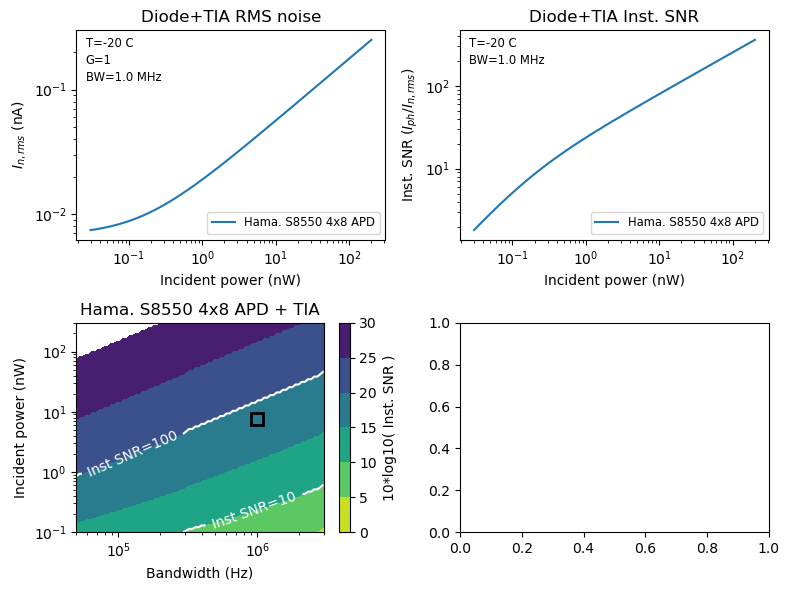

In [3]:
ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

p_inc = np.geomspace(0.03,200) * 1e-9 # incident power [W]
temp = -20  # temp C
bw = 1e6  # Hz
f_space = np.geomspace(1e3, bw)  # Hz
f_intervals = np.diff(f_space, prepend=0)  # Hz

iplot = 0

# diode+TIA noise vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Diode+TIA RMS noise')
diode_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc) + \
    diode.dark_current_shot_noise_CNPD(t=temp) + \
    diode.shunt_noise_CNPD(t=temp)
feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
gate_noise_CNPD = tia.gate_noise_CNPD()
diode_junction_cap = diode.junction_cap()
enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
enc_noise_total = np.sum(enc_noise_CNPD * f_intervals)/bw
TIA_noise_CNPD = enc_noise_total + gate_noise_CNPD + feedback_noise_CNPD
rms_noise = np.sqrt((diode_CNPD + TIA_noise_CNPD) / diode.gain**2 * bw)
plt.loglog(
    p_inc*1e9,
    rms_noise*1e9,
    label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('$I_{n,rms}$ (nA)')
plt.legend(fontsize='small', loc='lower right')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1', (0.03,0.84), xycoords='axes fraction', fontsize='small')
plt.annotate(f'BW={bw/1e6:.1f} MHz', (0.03,0.76), xycoords='axes fraction', fontsize='small')
iplot+=1

# diode+TIA SNR vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Diode+TIA Inst. SNR')
photocurrent = diode.photocurrent(p_inc) / diode.gain
diode_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc) + \
    diode.dark_current_shot_noise_CNPD(t=temp) + \
    diode.shunt_noise_CNPD(t=temp)
feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
gate_noise_CNPD = tia.gate_noise_CNPD()
diode_junction_cap = diode.junction_cap()
enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
enc_noise_total = np.sum(enc_noise_CNPD * f_intervals)/bw
TIA_noise_CNPD = enc_noise_total + gate_noise_CNPD + feedback_noise_CNPD
rms_noise = np.sqrt((diode_CNPD + TIA_noise_CNPD) / diode.gain**2 * bw)
SNR = photocurrent / rms_noise
plt.loglog(
    p_inc*1e9,
    SNR,
    label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('Inst. SNR ($I_{ph}/I_{n,rms}$)')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate(f'BW={bw/1e6:.1f} MHz', (0.03,0.84), xycoords='axes fraction', fontsize='small')
plt.legend(fontsize='small', loc='lower right')
iplot+=1


# SNR contours vs BW, P_inc
np_inc, nbw = 80, 80
p_inc_array = np.geomspace(1e-1,3e2,np_inc) * 1e-9  # W
f_max=3e6  # Hz
f_space = np.geomspace(1e3,f_max,80)  # Hz
f_intervals = np.diff(f_space, prepend=0)  # Hz
bw_ref_array = np.geomspace(50e3,f_max,nbw)  # Hz

plt.sca(axes.flat[iplot])
plt.title(f'{diode.name} + TIA')
SNR = np.zeros((np_inc, nbw))
for ip, p_inc in enumerate(p_inc_array):
    I_photo = diode.photocurrent(p_inc=p_inc)
    diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz
    feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
    gate_noise_CNPD = tia.gate_noise_CNPD()
    diode_junction_cap = diode.junction_cap()
    enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
    TIA_noise_NCPD = enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD
    total_noise = TIA_noise_NCPD + diode_CNPD
    noise_times_bw = total_noise * f_intervals
    for ibw, bw_ref in enumerate(bw_ref_array):
        int_noise = np.sqrt(np.sum(noise_times_bw[f_space<=bw_ref]))  # I_n,rms
        SNR[ip, ibw] = I_photo / int_noise
plt.contourf(
    bw_ref_array, 
    p_inc_array*1e9, 
    10*np.log10(SNR),
    levels=np.linspace(0,30,7),
    cmap='viridis_r'
    )
plt.xscale('log')
plt.xlabel('Bandwidth (Hz)')
plt.yscale('log')
plt.ylabel('Incident power (nW)')
plt.clim(0,30)
cb = plt.colorbar()
cb.set_label('10*log10( Inst. SNR )')
clines = plt.contour(
    bw_ref_array, 
    p_inc_array*1e9, 
    10*np.log10(SNR),
    levels=[10,20], colors='w')
plt.clabel(clines, colors='w', fmt={10:'Inst SNR=10', 20:'Inst SNR=100'})
# box marker for approximate location
plt.plot(1e6, 7.5, 'sk', ms=8, mew=2, fillstyle='none')

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/detector_noise_contours.pdf')

Noise, beam emission, and plasma fluctuation spectrum
=====

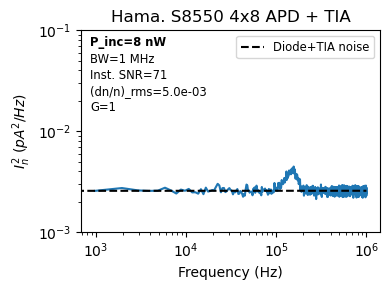

In [6]:
p_inc = 8e-9  # power on diode [W]
# power on diode =
#   beam radiance [W/m^2/ster]  (integral over wavelength of spectral radiance [W/nm/m^2/ster] * filter passband)
#   * collection etendue [m^2-ster]  (etendue = pi * fiber area * NA^2)
#   * transmisison

# beam radiance ~ 1e18 photons/s/m^2/ster  (convert photons/s -> W)
# etendue ~ 0.05 mm^2-ster (convert mm^2 -> m^2)
# transmission ~ 50% from all optics and fibers
# power on diode ~ 5-10 nW

n_rms = 5e-3  # plasma density RMS fluctuation

p_rms = p_inc * (0.5 * n_rms)  # incident power RMS fluctuation
        # (dI/I)/(dn/n) = 0.5 corresponds to high n ~ 1e20/cm**3
f0 = 150e3  # mode center frequency, Hz
f_fwhm = 50e3  # mode FWHM, Hz
f_sd = f_fwhm / ( 2 * np.sqrt(2*np.log(2)) )  # mode frequency std. dev., Hz

f_sample = 2.e6
bw = f_sample/2

temp = -20  # photodiode temperature, C


nfft = 2048
nbins = 256*2
nsamples = nfft * nbins

freqs = scipy.fft.rfftfreq(nfft, 1/f_sample)
nfreqs = nfft//2 + 1
assert(freqs.size == nfreqs)
fres = freqs[1]
assert(fres == f_sample / nfft)

freqs_full = scipy.fft.rfftfreq(nsamples, 1/f_sample)

ncols, nrows = 1, 1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

plt.sca(axes)
plt.title(f'{diode.name} + TIA')

# diode CNPD (current noise power density)
diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
    diode.dark_current_shot_noise_CNPD(t=temp) + \
    diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz

# TIA CNPD
feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
gate_noise_CNPD = tia.gate_noise_CNPD()
diode_junction_cap = diode.junction_cap()
enc_noise_CNPD = tia.enc_noise_CNPD(f=freqs, diode_junction_cap=diode_junction_cap)

# total noise CNPD
total_noise_CNPD = (enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD + diode_CNPD) / diode.gain**2

# RMS noise and SNR
i_rms = np.sqrt(np.mean(total_noise_CNPD) * bw)  # I_n,rms
I_photo = diode.photocurrent(p_inc=p_inc) / diode.gain
SNR = I_photo / i_rms

# noise fourier components
enc_noise_CNPD_full = tia.enc_noise_CNPD(f=freqs_full, diode_junction_cap=diode_junction_cap)
total_noise_CNPD_full = (enc_noise_CNPD_full + gate_noise_CNPD + feedback_noise_CNPD + diode_CNPD) / diode.gain**2
amplitudes = np.sqrt( total_noise_CNPD_full * bw * nsamples) * rng.standard_normal(freqs_full.size)
amplitudes[0] = I_photo * nsamples
phases = 2*np.pi * rng.random(freqs_full.size) 
phases[0] = 0
fourier_comp = amplitudes * np.exp(1.j * phases)

# plasma perturbation fourier components
I_rms = diode.photocurrent(p_inc=p_rms) / diode.gain
i2_mean_mode = I_rms**2 / bw
i2_f_mode_rel = np.exp(-0.5*(freqs_full-f0)**2 / f_sd**2)
i2_f_mode = i2_mean_mode * i2_f_mode_rel / np.mean(i2_f_mode_rel)
amplitudes = np.sqrt( i2_f_mode * bw * nsamples) * rng.standard_normal(freqs_full.size)
amplitudes[0] = 0
phases = 2*np.pi * rng.random(freqs_full.size) 
phases[0] = 0

# total fourier components and signal
fourier_comp = fourier_comp + amplitudes * np.exp(1.j * phases)
signal = np.real( scipy.fft.irfft(fourier_comp) )

psd = np.empty([nfreqs, nbins])
for i in np.arange(nbins):
    rfft = scipy.fft.rfft( signal[nfft*i:nfft*(i+1)] )
    psd[:,i] = np.abs(rfft) ** 2 / bw / nfft
psd_mean = np.mean(psd, axis=1)

plt.loglog(freqs[1:], psd_mean[1:]*1e24)
plt.loglog(freqs, total_noise_CNPD*1e24, label='Diode+TIA noise', c='k', ls='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$I_n^2$ ($pA^2/Hz$)')
plt.ylim(1e-3,1e-1)
plt.annotate(f'P_inc={p_inc*1e9:.0f} nW',
    xycoords='axes fraction',
    xy=[0.03,0.92],
    fontsize='small',
    fontweight='bold')
plt.annotate(f'BW={bw/1e6:.0f} MHz',
    xycoords='axes fraction',
    xy=[0.03,0.84],
    fontsize='small')
plt.annotate(f'Inst. SNR={SNR:.0f}',
    xycoords='axes fraction',
    xy=[0.03,0.76],
    fontsize='small')
plt.annotate(f'(dn/n)_rms={n_rms:.1e}',
    xycoords='axes fraction',
    xy=[0.03,0.68],
    fontsize='small')
if isinstance(diode, detectors.ApdDiode):
    plt.annotate(f'G=1',
        xycoords='axes fraction',
        xy=[0.03,0.60],
        fontsize='small')
plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/detector_simulated_signals.pdf')